<a href="https://colab.research.google.com/github/russtintolentino24/Predictive-Analysis-and-Load-Identification-for-Smart-Energy-Meters/blob/main/CO_v4_(Power_Readings).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install and import all necessary libraries.

In [ ]:
 pip install numpy

In [ ]:
pip install sklearn

In [ ]:
pip install kneed

In [ ]:
import pickle

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
import numpy as np
import pandas as pd
from math import isnan

Mounted at /content/drive


In [ ]:
from sklearn.cluster import KMeans
from kneed import KneeLocator

In [ ]:
import matplotlib.pyplot as plt

Check data

In [ ]:
col_names = ["time", "power", "apparent_power", "reactive_power", "factor", "voltage", "current"]
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/11-30-cleansed.csv', names = col_names, header = None)
data = data[1:]
data = pd.DataFrame(data, columns = ["power"])
data.astype(float)
data = np.asarray(data)
data = [float(x) for x in data]
data = [int(x) for x in data]
data = pd.DataFrame(data, columns = ['power'])
data

,power
0,125
1,125
2,125
3,125
4,125
...,...
3372,17
3373,15
3374,13
3375,18


# Data Preprocessing

In [ ]:
def kmeans():  
  col_names = ["time", "power", "apparent_power", "reactive_power", "factor", "voltage", "current"]
  data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/11-30-cleansed.csv', names = col_names, header = None)
  data = pd.DataFrame(data, columns = ['power'])
  data = data[1:]
  data = np.asarray(data)
  data = [float(x) for x in data]
  data = [int(x) for x in data]
  data = pd.DataFrame(data, columns = ['power'])


  sse = []
  k_rng = range(1,50)
  for k in k_rng:
      km = KMeans(n_clusters = k)
      SDFA = np.asarray(data).reshape(-1, 1)
      arr = np.array(data['power'].tolist())
      arrr = arr.reshape(-1, 1)
      km.fit(data)
      sse.append(km.inertia_)

  plt.xlabel('K')
  plt.ylabel('Sum of squared error')
  plt.plot(k_rng,sse)

  kn = KneeLocator(k_rng, sse, curve='convex', direction='decreasing')
  print(kn.knee)
  km_predicted = KMeans(n_clusters = kn.knee)
  y_predicted = km_predicted.fit_predict(data)

  data['cluster'] = y_predicted
  return data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (44) found smaller than n_clusters (45). Possibly due to duplicate points in X.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (44) found smaller than n_clusters (46). Possibly due to duplicate points in X.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (44) found smaller than n_clusters (47). Possibly due to duplicate points in X.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (44) found smaller than n_clusters (48). Possibly due to duplicate points in X.


3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (44) found smaller than n_clusters (49). Possibly due to duplicate points in X.


,power,cluster
0,125,2
1,125,2
2,125,2
3,125,2
4,125,2
...,...,...
3372,17,0
3373,15,0
3374,13,0
3375,18,0


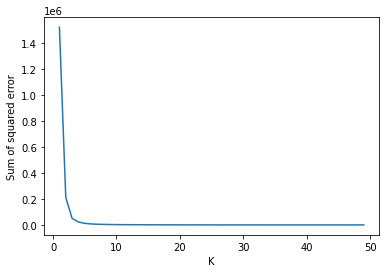

In [ ]:
#Functionality Check
kmeans()


1. Input from KMeans function output.
2. Filter each file such that only the nonzero values will be considered.
3. For optimization, limit the number of data points to 1000.
4. Combine all the appliances' data into one dataframe.

In [ ]:
def prepData():
  kmeans_data = kmeans()
  kmeans_data = pd.DataFrame(kmeans_data, columns = ['power', 'cluster'])
  col_names = ['time', 'power']
  # print(kmeans_data)
  c0 = kmeans_data.loc[kmeans_data['cluster'] == 0]
  c1 = kmeans_data.loc[kmeans_data['cluster'] == 1]
  c2 = kmeans_data.loc[kmeans_data['cluster'] == 2]

  c0 = c0[c0['power'] != 0]
  c0.reset_index(drop = True, inplace = True)
  c1 = c1[c1['power'] != 0]
  c1.reset_index(drop = True, inplace = True)
  c2 = c2[c2['power'] != 0]
  c2.reset_index(drop = True, inplace = True)

  c0_lim = c0.loc[1:1000, ['power']]
  c1_lim = c1.loc[1:1000, ['power']]
  c2_lim = c2.loc[1:1000, ['power']]

  zero_df = pd.DataFrame(0, index = range(1000), columns = range(1))
  zero_df.index = np.arange(1, len(zero_df) + 1)

  #individual appliances
  df_c0 = pd.concat([c0_lim, c0_lim, zero_df, zero_df], axis = 1)
  df_c0 = df_c0.set_axis(['total', 'c0', 'c1', 'c2'], axis = 1)
  df_c1 = pd.concat([c1_lim, zero_df, c1_lim, zero_df], axis = 1)
  df_c1 = df_c1.set_axis(['total', 'c0', 'c1', 'c2'], axis = 1)
  df_c2 = pd.concat([c2_lim, zero_df, zero_df, c2_lim], axis = 1)
  df_c2 = df_c2.set_axis(['total', 'c0', 'c1', 'c2'], axis = 1)
  df = pd.concat([df_c0, df_c1, df_c2], axis = 0, ignore_index = True)

  #by twos
  c0_1 = pd.concat([c0_lim + c1_lim, c0_lim, c1_lim, zero_df], axis = 1)
  c0_1 = c0_1.set_axis(['total', 'c0', 'c1', 'c2'], axis = 1)
  c0_2 = pd.concat([c0_lim + c2_lim, c0_lim, zero_df, c2_lim], axis = 1)
  c0_2 = c0_2.set_axis(['total', 'c0', 'c1', 'c2'], axis = 1)
  c1_2 = pd.concat([c1_lim + c2_lim, zero_df, c1_lim, c2_lim], axis = 1)
  c1_2 = c1_2.set_axis(['total', 'c0', 'c1', 'c2'], axis = 1)
  df = pd.concat([df, c0_1, c0_2, c1_2], axis = 0, ignore_index=True)

  #all
  c0_1_2 = pd.concat([c0_lim + c1_lim + c2_lim, c0_lim, c1_lim, c2_lim], axis = 1)
  c0_1_2 = c1_2.set_axis(['total', 'c0', 'c1', 'c2'], axis = 1)
  df = pd.concat([df, c0_1_2], axis = 0, ignore_index = True)
  # df.c0.astype(float)
  # df.c1.apply(float)
  # df.c2.apply(float)
  # df.total.apply(float)

  # for i, rows in df.iterrows():
  #   if isnan(rows.c0):
  #     df.c0.iloc[i] = 0
  # for i, rows in df.iterrows():
  #   if isnan(rows.c1):
  #     df.c1.iloc[i] = 0      
  # for i, rows in df.iterrows():
  #   if isnan(rows.c2):
  #     df.c2.iloc[i] = 0      
  # for i, rows in df.iterrows():
  #   if isnan(rows.total):
  #     df.total.iloc[i] = 0         

  return df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (44) found smaller than n_clusters (45). Possibly due to duplicate points in X.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (44) found smaller than n_clusters (46). Possibly due to duplicate points in X.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (44) found smaller than n_clusters (47). Possibly due to duplicate points in X.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (44) found smaller than n_clusters (48). Possibly due to duplicate points in X.


3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (44) found smaller than n_clusters (49). Possibly due to duplicate points in X.


,total,c0,c1,c2
0,27.0,27,0.0,0
1,20.0,20,0.0,0
2,20.0,20,0.0,0
3,22.0,22,0.0,0
4,21.0,21,0.0,0
...,...,...,...,...
6995,NaN,0,NaN,50
6996,NaN,0,NaN,51
6997,NaN,0,NaN,51
6998,NaN,0,NaN,51


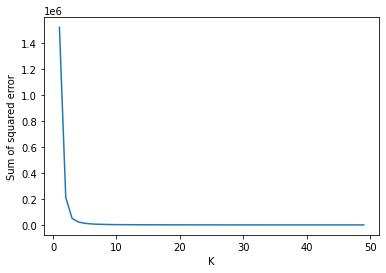

In [ ]:
df = prepData()
df

# Load Disaggregation
Source: https://github.com/amzkit/load-disaggregation/blob/master/co_model.py
Modified to be able to cater to the created dataset on v4 and v5.

In [ ]:
def cluster(X, max_num_clusters = 4, exact_num_clusters = None):
  data = _transform_data(X)

  centroids = _apply_clustering(data, max_num_clusters, exact_num_clusters)
  centroids = np.append(centroids, 0)
  centroids = np.round(centroids).astype(np.int32)
  centroids = np.unique(centroids)

  return centroids

In [ ]:
def _transform_data(data):
  MAX_NUMBER_OF_SAMPLES = 2000
  MIN_NUMBER_OF_SAMPLES = 20
  DATA_THRESHOLD = 1

  data_above_thresh = data[data > DATA_THRESHOLD].dropna().values
  print(data_above_thresh)
  n_samples = len(data_above_thresh)
  if n_samples < MIN_NUMBER_OF_SAMPLES:
    return np.zeros((MAX_NUMBER_OF_SAMPLES, 1))
  elif n_samples > MAX_NUMBER_OF_SAMPLES:
    random_indices = np.random.randint(0, n_samples, MAX_NUMBER_OF_SAMPLES)
    resampled = data_above_thresh[random_indices]
    return resampled.reshape(MAX_NUMBER_OF_SAMPLES, 1)
  else:
    return data_above_thresh.reshape(n_samples, 1)

In [ ]:
#FUNCTIONALITY CHECK
# df = labelData()
data = pd.DataFrame(df, columns = ["total"])
data.head()

,total
0,27.0
1,20.0
2,20.0
3,22.0
4,21.0


In [ ]:
#FUNCTIONALITY CHECK
td = _transform_data(data)
td

[[ 27.]
 [ 20.]
 [ 20.]
 ...
 [172.]
 [173.]
 [173.]]


array([[68.],
       [69.],
       [49.],
       ...,
       [66.],
       [49.],
       [61.]])

In [ ]:
def _apply_clustering_n_clusters(X, n_clusters):
  from sklearn.cluster import KMeans
  k_means = KMeans(init = 'k-means++', n_clusters = n_clusters)
  k_means.fit(X)
  return k_means.labels_, k_means.cluster_centers_

In [ ]:
def _apply_clustering(X, max_num_clusters, exact_num_clusters = None):
  from sklearn import metrics
  import warnings
  warnings.filterwarnings("ignore", category = DeprecationWarning)
  
  num_clus = -1 
  sh = -1
  k_means_labels = {}
  k_means_cluster_centers = {}
  k_means_labels_unique = {}

  if exact_num_clusters is not None:
    labels, centers = _apply_clustering_n_clusters(X, exact_num_clusters)
    return centers.flatten()

  for n_clusters in range(1, max_num_clusters):
    try:
      labels, centers = _apply_clustering_n_clusters(X, n_clusters)
      k_means_labels[n_clusters] = labels
      k_means_cluster_centers[n_clusters] = centers
      k_means_labels_unique[n_clusters] = np.unique(labels)
      try:
        sh_n = metrics.silhouette_score(
            X, k_means_labels[n_clusters], metric = 'euclidean')
        
        if sh_n > sh:
          sh = sh_n
          num_clus = n_clusters
      except Exception:
        num_clus = n_clusters
    except Exception:
      if num_clus > -1:
        return k_means_cluster_centers[num_clus]  
      else:
        return np.array([0])

  return k_means_cluster_centers[num_clus].flatten()

In [ ]:
#FUNCTIONALITY CHECK
centroids = cluster(data)
print(centroids)
len(centroids)

[[ 27.]
 [ 20.]
 [ 20.]
 ...
 [172.]
 [173.]
 [173.]]
[  0  14  57 151]


4

In [ ]:
def find_nearest(known_array, test_array):
  index_sorted = np.argsort(known_array)
  known_array_sorted = known_array[index_sorted]

  idx1 = np.searchsorted(known_array_sorted, test_array)
  idx2 = np.clip(idx1 - 1, 0, len(known_array_sorted) - 1)
  idx3 = np.clip(idx1,     0, len(known_array_sorted) - 1)

  diff1 = known_array_sorted[idx3] - test_array
  diff2 = test_array - known_array_sorted[idx2]

  indices = index_sorted[np.where(diff1 <= diff2, idx3, idx2)]
  residuals = test_array - known_array[indices]

  return indices, residuals

In [ ]:
class CO():
  def __init__(self, debug=False):
    self.model = []
    self.state_combinations = None
    self.MIN_CHUNK_LENGTH = 50
    self.MODEL_NAME = 'CO'
    self.debug = debug
    if self.debug : print("[CO Initialised]")

  def train(self, df, appliance_list):
    if self.model:
      raise RuntimeError("This implementation of Combinatorial Optimisation"
        " does not support multiple calls to 'train")
      
    max_num_clusters = 2

    for i, meter in enumerate(appliance_list):
      if self.debug : print(" [train] Training model for submeter", meter)
      meter_data = df[meter]

      num_on_states = None
      self.train_on_chunk(meter_data, meter, max_num_clusters, num_on_states)

  def train_on_chunk(self, chunk, meter, max_num_clusters, num_on_states):
    meters_in_model = [d['training_metadata'] for d in self.model]
    if meter in meters_in_model:
      raise RuntimeError("Meter {} is already in model!"
        " Can't train twice on the same meter!".format(meter))
    
    states = cluster(chunk, max_num_clusters, num_on_states)
    self.model.append({
        'states': states,
        'training_metadata': meter})
    print(" [train_on_chunk] Done training!")

  def disaggregate(self, df):
    if not 'total' in df:
      print("[CO_model][disaggregate] Could not detect column \"total\" in the given dataframe")
      return
    
    mains = df['total']

    if not self.model:
      raise RuntimeError("The model needs to be instantiated before"
        " calling `disaggregate`. The model"
        " can be instantiated by calling `train`.")
    
    if len(mains) < self.MIN_CHUNK_LENGTH:
      raise RuntimeError("Chunk is too short.")

    import warnings
    warnings.filterwarnings("ignore", category = DeprecationWarning)

    self._set_state_combinations_if_necessary()

    state_combinations = self.state_combinations
    print("state combinations:")
    print(state_combinations)

    summed_power_of_each_combinations = np.sum(state_combinations, axis = 1)

    indices_of_state_combinations, residual_power = find_nearest(
        summed_power_of_each_combinations, mains)
    
    appliance_powers_dict = {}
    for i, model in enumerate(self.model):
      print("Estimating power demand for '{}'"
        .format(model['training_metadata']))
      predicted_power = state_combinations[indices_of_state_combinations, i].flatten()
      column = pd.Series(predicted_power, index = mains.index, name = i)
      appliance_powers_dict[self.model[i]['training_metadata']] = column
    
    appliance_powers = pd.DataFrame(appliance_powers_dict, dtype='float32')
    appliance_powers_dict = pd.to_datetime(df['total'], unit = 's')

    return appliance_powers

  def _set_state_combinations_if_necessary(self):
    if(self.state_combinations is None or self.state_combinations.shape[1] != len(self.model)):
      from sklearn.utils.extmath import cartesian
      centroids = [model['states'] for model in self.model]
      self.state_combinations = cartesian(centroids)

  def save(self, filename):
    with open(filename+'.pkl', 'wb') as output:
        pickle.dump(self.model, output, pickle.HIGHEST_PROTOCOL)
        pickle.dump(self.state_combinations, output, pickle.HIGHEST_PROTOCOL)
            
  def load(self, filename):
    with open(filename+'.pkl', 'rb') as input:
        self.model = pickle.load(input)
        self.state_combinations = pickle.load(input)

Separate data to test and train sets.

In [ ]:
def separate_data():
  df = prepData()
  
  #label data
  df['label'] = ''
  for i, row in df.iterrows():
    label_str = ''
    if row.c0 != 0:
      label_str = "c0"
    if row.c1 != 0:
      label_str = label_str + "c1"
    if row.c2 != 0:
      label_str = label_str + "c2"
    df.label[i] = label_str

  #separate train and test set by 80-20
  y = pd.DataFrame(df, columns = ['label'])
  x = pd.DataFrame(df, columns = ['total', 'c0', 'c1', 'c2', 'label'])
  # print(y)
  # print(x)

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
  # x_train 
  return x_train, x_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (44) found smaller than n_clusters (45). Possibly due to duplicate points in X.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (44) found smaller than n_clusters (46). Possibly due to duplicate points in X.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (44) found smaller than n_clusters (47). Possibly due to duplicate points in X.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (44) found smaller than n_clusters (48). Possibly due to duplicate points in X.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (44) found smaller than n_clusters (49). Possibly due to duplicate points in X.
/usr/local/lib/python3.7/dist-packa

3


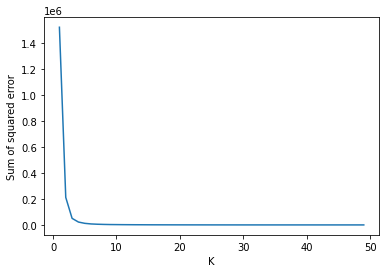

In [ ]:
x_train, x_test = separate_data()

In [ ]:
x_train = pd.DataFrame(x_train, columns = ['total', 'c0', 'c1', 'c2'])
x_train

,total,c0,c1,c2
5681,NaN,0,51,NaN
641,20.0,20,0,0.0
1140,51.0,0,51,0.0
2314,NaN,0,0,NaN
5239,NaN,0,53,NaN
...,...,...,...,...
3775,60.0,8,52,0.0
571,16.0,16,0,0.0
6000,176.0,0,51,125.0
6934,NaN,0,50,NaN


In [ ]:
x_test_unique_total = x_test.drop_duplicates(subset = 'total') 
x_test_unique_total

,total,c0,c1,c2,label
1353,50.0,0,50,0.0,c1
4952,NaN,11,0,NaN,c0c2
1772,51.0,0,51,0.0,c1
779,8.0,8,0,0.0,c0
618,15.0,15,0,0.0,c0
...,...,...,...,...,...
3277,76.0,24,52,0.0,c0c1
3935,57.0,7,50,0.0,c0c1
4004,146.0,21,0,125.0,c0c2
930,7.0,7,0,0.0,c0


In [ ]:
x_test_orig = pd.DataFrame(x_test_unique_total, columns = ["total"])
x_test_index = x_test_orig.index
# x_test = x_test.total.unique()
# x_test = pd.DataFrame(x_test, columns = ["total"])
x_test = x_test_orig.reset_index()
x_test.head(10)

,index,total
0,1353,50.0
1,4952,NaN
2,1772,51.0
3,779,8.0
4,618,15.0
5,1157,52.0
6,290,22.0
7,221,10.0
8,703,14.0
9,3092,68.0


In [ ]:
x_test_index

Int64Index([1353, 4952, 1772,  779,  618, 1157,  290,  221,  703, 3092,  100,
             706, 5016, 3922,  970,  112, 3944, 3078, 3666, 3441,   46,  227,
            4020, 3320, 1196,  650, 3004, 3323,   15, 1841, 3246,  875,  503,
            3604, 3896, 3700,  660, 6024,   90,  526, 2013,  488, 5015, 3119,
            6019, 3671, 3003, 1699, 2010, 6002, 4008, 1550, 1640, 3510, 1329,
             282, 3277, 3935, 4004,  930, 3669],
           dtype='int64')

In [ ]:
#FUNCTIONALITY TEST
list_of_appliance = ['c0', 'c1', 'c2']
co = CO()
co.train(x_train, list_of_appliance)

[20 12 10 ...  8 16 19]
 [train_on_chunk] Done training!
[51 51 53 ... 52 51 50]
 [train_on_chunk] Done training!
[123. 123. 122. 123. 125. 125. 123. 123. 123. 123. 122. 123. 123. 123.
 122. 123. 123. 125. 125. 123. 123. 123. 126. 125. 123. 123. 123. 123.
 123. 125. 123. 126. 123. 125. 123. 123. 123. 125. 125. 125. 123. 123.
 126. 123. 123. 123. 125. 123. 123. 125. 123. 124. 123. 123. 123. 125.
 125. 125. 123. 123. 123. 125. 125. 123. 122. 125. 125. 123. 123. 125.
 123. 123. 123. 122. 123. 125. 123. 125. 125. 125. 123. 125. 123. 122.
 123. 123. 124. 123. 124. 123. 123. 123. 123. 125. 124. 123. 123. 122.
 125.]
 [train_on_chunk] Done training!


In [ ]:
co.save("co_trained_model")

In [ ]:
x_test.head(10)

,index,total
0,1353,50.0
1,4952,NaN
2,1772,51.0
3,779,8.0
4,618,15.0
5,1157,52.0
6,290,22.0
7,221,10.0
8,703,14.0
9,3092,68.0


In [ ]:
x_test = pd.DataFrame(x_test, columns = ["total"])
prediction = co.disaggregate(x_test)

state combinations:
[[  0   0   0]
 [  0   0 124]
 [  0  51   0]
 [  0  51 124]
 [ 14   0   0]
 [ 14   0 124]
 [ 14  51   0]
 [ 14  51 124]]
Estimating power demand for 'c0'
Estimating power demand for 'c1'
Estimating power demand for 'c2'


In [ ]:
print(prediction.head(20))

      c0    c1     c2
0    0.0  51.0    0.0
1   14.0  51.0  124.0
2    0.0  51.0    0.0
3   14.0   0.0    0.0
4   14.0   0.0    0.0
5    0.0  51.0    0.0
6   14.0   0.0    0.0
7   14.0   0.0    0.0
8   14.0   0.0    0.0
9   14.0  51.0    0.0
10  14.0   0.0    0.0
11  14.0   0.0    0.0
12   0.0  51.0  124.0
13  14.0  51.0    0.0
14  14.0   0.0    0.0
15  14.0   0.0    0.0
16  14.0  51.0    0.0
17  14.0  51.0    0.0
18  14.0  51.0    0.0
19  14.0  51.0    0.0


In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
prediction[prediction['c2'] != 0]

,c0,c1,c2
1,14.0,51.0,124.0
12,0.0,51.0,124.0
22,14.0,0.0,124.0
37,0.0,51.0,124.0
40,0.0,0.0,124.0
42,0.0,51.0,124.0
44,0.0,51.0,124.0
48,0.0,0.0,124.0
49,0.0,51.0,124.0
50,14.0,0.0,124.0


In [ ]:
prediction['label'] = ''
for i, row in prediction.iterrows():
  label_str = ''
  if row.c0 != 0:
    label_str = "c0"
  if row.c1 != 0:
    label_str = label_str + "c1"
  if row.c2 != 0:
    label_str = label_str + "c2"
  
  prediction.label[i] = label_str

prediction.tail(20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,c0,c1,c2,label
41,14.0,0.0,0.0,c0
42,0.0,51.0,124.0,c1c2
43,14.0,51.0,0.0,c0c1
44,0.0,51.0,124.0,c1c2
45,14.0,51.0,0.0,c0c1
46,14.0,51.0,0.0,c0c1
47,0.0,51.0,0.0,c1
48,0.0,0.0,124.0,c2
49,0.0,51.0,124.0,c1c2
50,14.0,0.0,124.0,c0c2


Test Data Plot

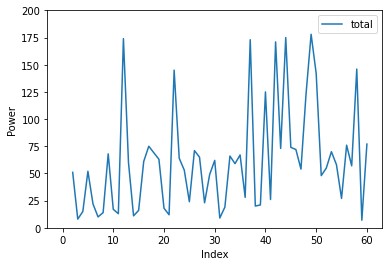

In [ ]:
x_test_total = x_test_unique_total.reset_index(drop=True)
x_test_total = pd.DataFrame(x_test_total, columns = ["total"])
x_test_total.plot()
plt.ylim([0, 200])
plt.ylabel('Power')
plt.xlabel('Index')
plt.show()

Prediction Results Plot

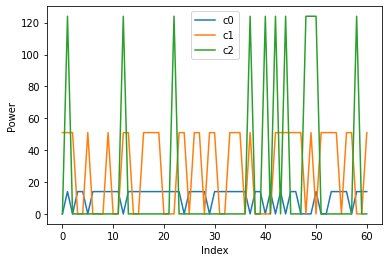

In [ ]:
prediction.plot()
plt.ylabel('Power')
plt.xlabel('Index')
plt.show()

In [ ]:
#CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
def plot(y_true, y_pred):
  labels = unique_labels(y_true)
  column = [f'Predicted {label}' for label in labels]
  indices = [f'Actual {label}' for label in labels]
  table = pd.DataFrame(confusion_matrix(y_true, y_pred), columns = column, index = indices)
  return table

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(x_test_unique_total.label, prediction.label))

0.9508196721311475


In [ ]:
from sklearn.metrics import classification_report
c_rep = classification_report(x_test_unique_total.label, prediction.label, zero_division= 0)
print(c_rep)

              precision    recall  f1-score   support

          c0       1.00      1.00      1.00        21
        c0c1       0.95      0.95      0.95        20
      c0c1c2       0.00      0.00      0.00         0
        c0c2       1.00      0.75      0.86         4
          c1       0.89      0.89      0.89         9
        c1c2       1.00      1.00      1.00         5
          c2       1.00      1.00      1.00         2

    accuracy                           0.95        61
   macro avg       0.83      0.80      0.81        61
weighted avg       0.97      0.95      0.96        61



# ***Appliance Presence Prediction***

# Use of Output shown:

1.   **Shows which Appliances are working based on specific index.** 
2.   **Determines if Appliance was detected to be working at given index**
3.   **Gives Index where Appliance is detected to be working**







Notes For Code
*   Get predicted value for each device
*   Check each index in prediction if the device is present
*   Show the indices where the devices are present
*   Multiple Conditions are set-up to adapt to the user's needs. Presence prediction can be done for multiple devices or single devices only.





In [ ]:
c0_pred = prediction['c0'].max()
c1_pred = prediction['c1'].max()
c2_pred = prediction['c2'].max()

print(c0_pred, c1_pred, c2_pred)


14.0 51.0 124.0


In [ ]:
boolDf_all = prediction.isin([c0_pred, c1_pred, c2_pred])
print(boolDf_all)

       c0     c1     c2  label
0   False   True  False  False
1    True   True   True  False
2   False   True  False  False
3    True  False  False  False
4    True  False  False  False
5   False   True  False  False
6    True  False  False  False
7    True  False  False  False
8    True  False  False  False
9    True   True  False  False
10   True  False  False  False
11   True  False  False  False
12  False   True   True  False
13   True   True  False  False
14   True  False  False  False
15   True  False  False  False
16   True   True  False  False
17   True   True  False  False
18   True   True  False  False
19   True   True  False  False
20   True  False  False  False
21   True  False  False  False
22   True  False   True  False
23   True   True  False  False
24  False   True  False  False
25   True  False  False  False
26   True   True  False  False
27   True   True  False  False
28   True  False  False  False
29  False   True  False  False
30   True   True  False  False
31   Tru

In [ ]:
c_all_exists = prediction.loc[(prediction['c0'] == c0_pred) & (prediction['c1'] == c1_pred) & (prediction['c2'] == c2_pred)]
print("All appliances exist in indices:", c_all_exists.index.values)

All appliances exist in indices: [1]


In [ ]:
boolDf_c0 = prediction.isin([c0_pred])
print(boolDf_c0)

       c0     c1     c2  label
0   False  False  False  False
1    True  False  False  False
2   False  False  False  False
3    True  False  False  False
4    True  False  False  False
5   False  False  False  False
6    True  False  False  False
7    True  False  False  False
8    True  False  False  False
9    True  False  False  False
10   True  False  False  False
11   True  False  False  False
12  False  False  False  False
13   True  False  False  False
14   True  False  False  False
15   True  False  False  False
16   True  False  False  False
17   True  False  False  False
18   True  False  False  False
19   True  False  False  False
20   True  False  False  False
21   True  False  False  False
22   True  False  False  False
23   True  False  False  False
24  False  False  False  False
25   True  False  False  False
26   True  False  False  False
27   True  False  False  False
28   True  False  False  False
29  False  False  False  False
30   True  False  False  False
31   Tru

In [ ]:
c0_exists = prediction.loc[prediction['c0'] == c0_pred]
print("fan exists in indices:", c0_exists.index.values)

fan exists in indices: [ 1  3  4  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 22 23 25 26 27 28
 30 31 32 33 34 35 36 38 39 41 43 45 46 50 53 54 55 56 58 59 60]


In [ ]:
boolDf_c1 = prediction.isin([c1_pred])
print(boolDf_c1)

       c0     c1     c2  label
0   False   True  False  False
1   False   True  False  False
2   False   True  False  False
3   False   True  False  False
4   False   True  False  False
5   False  False  False  False
6   False  False  False  False
7   False   True  False  False
8   False   True  False  False
9   False   True  False  False
10  False   True  False  False
11  False   True  False  False
12  False  False  False  False
13  False   True  False  False
14  False   True  False  False
15  False   True  False  False
16  False   True  False  False
17  False   True  False  False
18  False  False  False  False
19  False   True  False  False
20  False  False  False  False
21  False  False  False  False
22  False  False  False  False
23  False   True  False  False
24  False   True  False  False
25  False   True  False  False
26  False   True  False  False
27  False  False  False  False
28  False  False  False  False
29  False   True  False  False
30  False   True  False  False
31  Fals

In [ ]:
c1_exists = prediction.loc[prediction['c1'] == c1_pred]
print("Laptop exists in indices:", c1_exists.index.values)

Laptop exists in indices: [ 0  1  2  5  9 12 13 16 17 18 19 23 24 26 27 29 30 33 34 35 37 42 43 44
 45 46 47 49 51 52 53 54 56 57 60]


In [ ]:
c1_exists = prediction.loc[prediction.iloc[:,1] == c1_pred]
print(c1_exists.index.values)

[ 0  1  2  3  4  7  8  9 10 11 13 14 15 16 17 19 23 24 25 26 29 30 32 39
 40 43 44 46 47 49 50 51 54 55 57 58 59 64]


In [ ]:
print(prediction)

In [ ]:
boolDf_c2 = prediction.isin([c2_pred])
print(boolDf_c2)

       c0     c1     c2  label
0   False  False   True  False
1   False  False  False  False
2   False  False  False  False
3   False  False  False  False
4   False  False  False  False
5   False  False  False  False
6   False  False  False  False
7   False  False  False  False
8   False  False  False  False
9   False  False  False  False
10  False  False  False  False
11  False  False  False  False
12  False  False  False  False
13  False  False  False  False
14  False  False  False  False
15  False  False  False  False
16  False  False   True  False
17  False  False  False  False
18  False  False  False  False
19  False  False  False  False
20  False  False  False  False
21  False  False  False  False
22  False  False  False  False
23  False  False  False  False
24  False  False  False  False
25  False  False  False  False
26  False  False  False  False
27  False  False  False  False
28  False  False  False  False
29  False  False  False  False
30  False  False  False  False
31  Fals

In [ ]:
c2_exists = prediction.loc[prediction['c2'] == c2_pred]
print("TV exists in indices:", c2_exists.index.values)

TV exists in indices: [ 1 12 22 37 40 42 44 48 49 50 58]


# Use of Output shown:

1.   **Shows which Appliances are working based on specific index.** 
2.   **Determines if Appliance was detected to be working at given index**
3.   **Gives Index where Appliance is detected to be working**




